# Twitter Hate Tweets Detection -- Priyansh Kedia

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iampr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iampr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset

In [2]:
tweets_train = pd.read_csv('hate_text/train.csv')
tweets_test = pd.read_csv('hate_text/test.csv')

In [3]:
tweets_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
tweets_train.drop(['id'],axis=1,inplace=True)
tweets_train.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [5]:
unique, counts = np.unique(tweets_train.label, return_counts=True)
dict(zip(unique, counts))

{0: 29720, 1: 2242}

In [6]:
labels = ['Not-Hate', 'Hate']

# Extracting Hate Tweets and Non-Hate Tweets

In [7]:
hate_data = tweets_train[tweets_train['label']==1]

In [8]:
unique, counts = np.unique(hate_data.label, return_counts=True)
dict(zip(unique, counts))

{1: 2242}

In [9]:
non_hate_data = tweets_train[tweets_train['label']==0]
print(non_hate_data.shape)
unique, counts = np.unique(non_hate_data.label, return_counts=True)
dict(zip(unique, counts))

(29720, 2)


{0: 29720}

In [10]:
non_hate_data = non_hate_data.iloc[0:9000,:]
print(non_hate_data.shape)
unique, counts = np.unique(non_hate_data.label, return_counts=True)
dict(zip(unique, counts))

(9000, 2)


{0: 9000}

# Increasing Hate Tweets 3 Times to Balance Data

In [11]:
balanced_data = pd.concat([non_hate_data, hate_data], ignore_index=True)
print(balanced_data.shape)
unique, counts = np.unique(balanced_data.label, return_counts=True)
dict(zip(unique, counts))

(11242, 2)


{0: 9000, 1: 2242}

In [12]:
def increase(balanced_data,hate_data):
    for i in range(3):
        balanced_data = pd.concat([balanced_data, hate_data], ignore_index=True)
    
    print(balanced_data.shape)    
    unique, counts = np.unique(balanced_data.label, return_counts=True)
    print(dict(zip(unique, counts)))
    return balanced_data

In [13]:
balanced_data = increase(balanced_data , hate_data)

(17968, 2)
{0: 9000, 1: 8968}


In [14]:
balanced_data.describe()

,label
count,17968.000000
mean,0.499110
std,0.500013
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [15]:
balanced_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


# Text Preprossesing

In [16]:
#dealing with Slangs
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food', 'u': 'you', 
     'ur':'your', 'bday' : 'birthday', 'bihday' : 'birthday'} ## Need a huge dictionary

In [17]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = re.sub("hm+", "", text) #removing variants of hmmm
    text = re.sub("[^a-z]+", " ", text) #removing all numbers, special chars like @,#,? etc
    text = re.sub("user", "", text) #removing all numbers, special chars like @,#,? etc
    words = text.split()
    text = [d[word] if word in d else word for word in words]  #replacing some slangs
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

In [18]:
balanced_data['processed_tweets'] = balanced_data.tweet.apply(lambda x: clean_text(x))   # df.review.map(clean_text) Also can be used

In [19]:
balanced_data.head()

,label,tweet,processed_tweets
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit use cause offer wheelchair v...
2,0,bihday your majesty,birthday majesty
3,0,#model i love u take with u all the time in ...,model love take time
4,0,factsguide: society now #motivation,factsguide society motivation


# Word Frequency in Tweets

In [20]:
x = balanced_data.processed_tweets
y = balanced_data.label
print(x.shape)
print(y.shape)

(17968,)
(17968,)


In [21]:
# finding unique words
word_unique = []
for i in x:
    for j in i.split():
        word_unique.append(j)
unique, counts = np.unique(word_unique, return_counts=True)
print("The total words in the tweets are : ", len(word_unique))
print("The total UNIQUE words in the tweets are : ", len(unique))

The total words in the tweets are :  142680
The total UNIQUE words in the tweets are :  16798


In [22]:
#Sorting the Unique words based on their Frequency
col = list(zip(unique, counts))
col = sorted(col, key = lambda x: x[1],reverse=True)
col=pd.DataFrame(col)
print("Top 20 Occuring Words with their frequency are:")
col.iloc[:20,:]

Top 20 Occuring Words with their frequency are:


,0,1
0,amp,1660
1,love,1056
2,trump,927
3,day,916
4,like,881
5,get,823
6,go,661
7,people,653
8,white,651
9,black,642


In [23]:
col.describe()

,1
count,16798.000000
mean,8.493868
std,36.001059
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,1660.000000


"As we can see around 50% of the words are occuring only once and hence can be ignored, So we will Tokenize only 8500 words"

# Padding and Tokenizing

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [25]:
num_words = 8500
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>" )
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))
print("Mean is: ",np.mean(length))
print("Max is: ",np.max(length))
print("Min is: ",np.min(length))

17968
Mean is:  7.940783615316118
Max is:  21
Min is:  0


In [26]:
pad_length = 20
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')

# Model Building

In [27]:
from keras.layers import Dense , Input , GRU , Embedding, Dropout , Activation, Flatten, SimpleRNN
from keras.layers import GlobalMaxPool1D
from keras.models import Model, Sequential

In [28]:
model = Sequential([Embedding(num_words, embed_dim, input_length = pad_length),
                   SimpleRNN(8, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(20,activation = 'relu',kernel_initializer='he_uniform'),
                   Dropout(0.25),
                   Dense(1,activation = 'sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.name = 'Twitter Hate Text Classification'
model.summary()

Model: "Twitter Hate Text Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            272000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 8)             328       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 272,529
Trainable params: 272,529
Non-trainable params: 0
____________________________

In [29]:
y = np.array(y)

In [30]:
history = model.fit(x = sequences, y = y, batch_size= 32, epochs=3, validation_split = 0.05)

C:\Users\iampr\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 17069 samples, validate on 899 samples
Epoch 1/3
17069/17069 [==============================] - 30s 2ms/step - loss: 0.3161 - accuracy: 0.8622 - val_loss: 0.0691 - val_accuracy: 0.9811
Epoch 2/3
17069/17069 [==============================] - 24s 1ms/step - loss: 0.0591 - accuracy: 0.9845 - val_loss: 0.0471 - val_accuracy: 0.9855
Epoch 3/3
17069/17069 [==============================] - 36s 2ms/step - loss: 0.0275 - accuracy: 0.9937 - val_loss: 0.0453 - val_accuracy: 0.9889


In [31]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [32]:
import matplotlib
from matplotlib import pyplot as plt

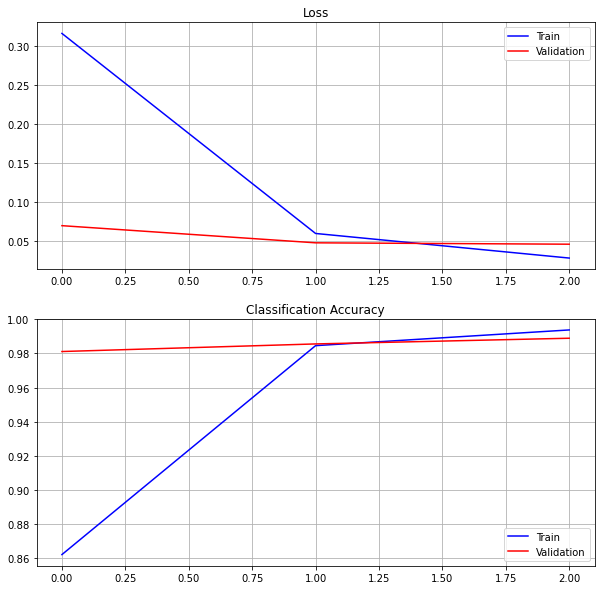

In [33]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.title('Loss')
plt.grid()
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Validation')
plt.legend()
# plot accuracy
fig.add_subplot(2, 1, 2)
plt.title('Classification Accuracy')
plt.grid()
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Validation')
plt.legend()

# Testing Data

In [34]:
tweets_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [35]:
tweets_test.drop(['id'],axis=1,inplace=True)

In [36]:
tweets_test['processed_tweets'] = tweets_test.tweet.apply(lambda x: clean_text(x))
tweets_test.head()

,tweet,processed_tweets
0,#studiolife #aislife #requires #passion #dedic...,studiolife aislife require passion dedication ...
1,@user #white #supremacists want everyone to s...,white supremacist want everyone see new bird m...
2,safe ways to heal your #acne!! #altwaystohe...,safe way heal acne altwaystoheal healthy heal
3,is the hp and the cursed child book up for res...,hp curse child book reservation already yes ha...
4,"3rd #bihday to my amazing, hilarious #nephew...",rd birthday amaze hilarious nephew eli air unc...


In [37]:
test_data = tweets_test.processed_tweets
test_data.shape

(17197,)

In [38]:
test_data = tokenizer.texts_to_sequences(test_data)
test_data = pad_sequences(test_data, maxlen = pad_length, truncating = 'pre', padding = 'post')

In [39]:
predictions = model.predict(test_data)

In [40]:
predictions = ['Not Hate' if x<=0.5 else 'Hate' for x in predictions]

In [43]:
array = np.random.randint(low=0,high=171,size=10)
for i in array:
    print("--"*50)
    print("The Original Tweet is : ",tweets_test.tweet.iloc[i])
    print("The Processed Tweet is : ",tweets_test.processed_tweets.iloc[i])
    print("The Prediction is: ",predictions[i])
    print("--"*50)

----------------------------------------------------------------------------------------------------
The Original Tweet is :  this lonely feeling when nobody let you be and live your little dream... even people you trusted... #disappointed   #lonely #broken
The Processed Tweet is :  lonely feel nobody let live little dream even people trust disappoint lonely break
The Prediction is:  Not Hate
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
The Original Tweet is :  boom! i've just booked my first #edfringe2016 ticket for this #australian #theatre performance!    ð
The Processed Tweet is :  boom book first edfringe ticket australian theatre performance
The Prediction is:  Not Hate
----------------------------------------------------------------------------------------------------
------------------------------------------------------